## The idea is:
- Feature reduction with PCA 
- Data transformation(log, hot-encoding, nan)
- Test different regression models

## Things found:
- Applying log transformation really increases the accuracy
- Using PCA with 36 components makes the learning and testing much faster
- Removing columns with more than 10000 NaNs gives better result than applying "mean" to them
- There are outliers,instead of removing them, using Huber seems to provide a good result. Huber is a model robust to outliers

## 1.Load libraries

In [103]:
import numpy as np
import pandas as pd

from sklearn.decomposition import PCA
from sklearn.preprocessing import Imputer

from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import make_scorer
from sklearn.metrics import r2_score

from sklearn import linear_model
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn import svm

import matplotlib.pyplot as plt
import seaborn

import warnings
warnings.filterwarnings('ignore')

# from subprocess import check_output
# print(check_output(["ls", "/data"]).decode("utf8"))

## 2.Data load

In [104]:
# import pymssql
# conn = pymssql.connect(host = "WANGZF-PC",
#                        port = '1433',
#                        user = "alvin.wang",
#                        password = "alvin123",
#                        database = "tinker",
#                        charset = "UTF-8")
# cur = conn.cursor()
# sql = "SELECT * FROM dbo.houseprice_train "
# conn.close()
# cur.execute(sql)
# result = cur.fetchall()
# print(result)

train = pd.read_csv("./data/train.csv")
test = pd.read_csv("./data/test.csv")

train_label = train["SalePrice"]
train = train.drop("SalePrice", axis = 1)

train_id = train["Id"]
test_id = test["Id"]

data = pd.concat([train, test], ignore_index = True)

## 3.Explor the data

In [105]:
print(train.shape)
print(train.shape)
print(data.shape)
print(train_label)
print(train_id)
print(test_id)

print("*" * 100)

print(data.info())

print("*" * 100)

print(data.head(6))

print("*" * 100)

nans = pd.isnull(data).sum().sort_values()
print(nans[nans > 0])

(1460, 80)
(1460, 80)
(2919, 80)
0       208500
1       181500
2       223500
3       140000
4       250000
5       143000
6       307000
7       200000
8       129900
9       118000
10      129500
11      345000
12      144000
13      279500
14      157000
15      132000
16      149000
17       90000
18      159000
19      139000
20      325300
21      139400
22      230000
23      129900
24      154000
25      256300
26      134800
27      306000
28      207500
29       68500
         ...  
1430    192140
1431    143750
1432     64500
1433    186500
1434    160000
1435    174000
1436    120500
1437    394617
1438    149700
1439    197000
1440    191000
1441    149300
1442    310000
1443    121000
1444    179600
1445    129000
1446    157900
1447    240000
1448    112000
1449     92000
1450    136000
1451    287090
1452    145000
1453     84500
1454    185000
1455    175000
1456    210000
1457    266500
1458    142125
1459    147500
Name: SalePrice, Length: 1460, dtype: int64
0       

## 4.Data Preprocessing

In [106]:
# Removing id and columns with more than 100 missing values
data = data.drop(["Id", "FireplaceQu", "Fence", "Alley", "MiscFeature", "PoolQC"], axis = 1)
data.dtypes.value_counts()

object     38
int64      25
float64    11
dtype: int64

In [107]:
# split categorical and non-categorical variables
all_columns = data.columns.values
non_categorical = ["LotFrontage", "LotArea", "MasVnrArea", "BsmtFinSF1", 
                   "BsmtFinSF2", "BsmtUnfSF", "TotalBsmtSF", "1stFlrSF", 
                   "2ndFlrSF", "LowQualFinSF", "GrLivArea", "GarageArea", 
                   "WoodDeckSF", "OpenPorchSF", "EnclosedPorch", "3SsnPorch", 
                   "ScreenPorch","PoolArea", "MiscVal"]
categorical = [value for value in all_columns if value not in non_categorical]
print(non_categorical)
print(categorical)

print("*" * 100)

# Apply hot encoding, convert categorical vailable into dummy / indicator variable
data = pd.get_dummies(data)

# Fill NaN with median for that column
imp = Imputer(missing_values = "NaN", strategy = "most_frequent", axis = 0)
data = imp.fit_transform(data)
print(pd.isnull(data).sum())

# Log transformation
data = np.log(data)
train_label = np.log(train_label)

# Change -inf to 0
data[data == np.inf] = 0
data[data == np.NINF] = 0

['LotFrontage', 'LotArea', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal']
['MSSubClass', 'MSZoning', 'Street', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'GarageType', 'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageQual', 'GarageCond', 'PavedDrive', 'MoSold', 'YrSold', 'SaleT

## 5.Feature reduction

In [108]:
pca = PCA(whiten = True)
pca.fit(data)
variance = pd.DataFrame(pca.explained_variance_ratio_)
np.cumsum(pca.explained_variance_ratio_)

array([0.2248857 , 0.40281429, 0.52425789, 0.62418823, 0.69580422,
       0.75944463, 0.8116806 , 0.85647038, 0.89178708, 0.92273755,
       0.94898868, 0.95842727, 0.96637545, 0.97380464, 0.97971901,
       0.98501952, 0.98918839, 0.99199181, 0.99386559, 0.99520919,
       0.99611479, 0.99695667, 0.99771023, 0.99842564, 0.9989402 ,
       0.99933882, 0.99959949, 0.99978254, 0.99988174, 0.99993998,
       0.99998599, 0.99999658, 0.99999871, 0.99999943, 0.99999999,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.     

In [109]:
pca = PCA(n_components = 36, whiten = True)
pca = pca.fit(data)
dataPCA = pca.transform(data)

## 6.Model Selection

### 6.1 Model  without PCA

,R Square Score
Linear,0.853790
Ridge,0.838624
Bayesian Ridge,0.852442
Huber,0.835497
Lasso,0.853935
Bagging,0.849798
RandomForest,0.843437
AdaBoost,0.798926
SVM RBF,0.812019
SVM Linear,0.849076


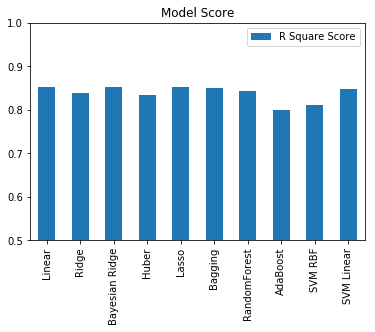

In [113]:
# training and testing dataset
train = data[:1460]
test = data[1460:]
train_lable = train_label

# R2 Score
def training(train, labels):
    results = {}
    def test_model(clf):
        cv = KFold(n_splits = 5, shuffle = True, random_state = 45)
        r2 = make_scorer(r2_score)
        r2_val_score = cross_val_score(clf, train, labels, cv = cv, scoring = r2)
        scores = [r2_val_score.mean()]
        return scores
    
    # Build models
    # Linear Regression
    clf = linear_model.LinearRegression()
    results["Linear"] = test_model(clf)
    
    # Ridge Regression
    clf = linear_model.Ridge()
    results["Ridge"] = test_model(clf)
    
    # Bayesian Ridge
    clf = linear_model.BayesianRidge()
    results["Bayesian Ridge"] = test_model(clf)
    
    # Hubber
    clf = linear_model.HuberRegressor()
    results["Huber"] = test_model(clf)
    
    # Lasso
    clf = linear_model.Lasso(alpha = 1e-4)
    results["Lasso"] = test_model(clf)
    
    # Bagging
    clf = BaggingRegressor()
    results["Bagging"] = test_model(clf)
    
    # Random Forest
    clf = RandomForestRegressor()
    results["RandomForest"] = test_model(clf)
    
    # AdaBoost
    clf = AdaBoostRegressor()
    results["AdaBoost"] = test_model(clf)
    
    # SVM RBF
    clf = svm.SVR()
    results["SVM RBF"] = test_model(clf)
    
    # SVM Linear
    clf = svm.SVR(kernel = "linear")
    results["SVM Linear"] = test_model(clf)
    
    results = pd.DataFrame.from_dict(results, orient = "index")
    results.columns = ["R Square Score"]
    # results = results.sort(columns = ["R Square Score"], ascending = False)
    results.plot(kind = "bar", title = "Model Score")
    axes = plt.gca()
    axes.set_ylim([0.5, 1])
    return results

trainNoPCA(train, train_label)

### 6.2 Model with PCA

,R Square Score
Linear,0.853790
Ridge,0.853826
Bayesian Ridge,0.853913
Huber,0.859652
Lasso,0.853862
Bagging,0.719414
RandomForest,0.719618
AdaBoost,0.672546
SVM RBF,0.791369
SVM Linear,0.858325


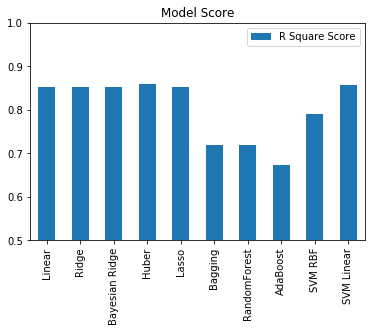

In [114]:
# Split training and testing datasets
train = dataPCA[:1460]
test = dataPCA[1460:]

training(train, train_label)

In [119]:
cv = KFold(n_splits = 5, shuffle = True, random_state = 45)
parameters = {
    "alpha": [1000, 100, 10],
    "epsilon": [1.2, 1.25, 1.50],
    "tol": [1e-10]
}
clf = linear_model.HuberRegressor()
r2 = make_scorer(r2_score)
grid_obj = GridSearchCV(clf, parameters, cv = cv, scoring = r2)
grid_fit = grid_obj.fit(train, train_label)
best_clf = grid_fit.best_estimator_
best_clf.fit(train, train_lable)

# Make Prediction with testing dataset
predictions_huber = best_clf.predict(test)
predictions_huber = np.exp(predictions_huber)
print(predictions_huber)

[125634.47967624 156328.59319084 188741.61426055 ... 177293.64859558
 124159.78139931 241313.58557214]
